In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats

**Main function**

Dropped columns: Id
Dropping columns with high missing data:  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
No duplicate columns found.
The target variable 'SalePrice' is present in the DataFrame.

-----------------------------Initial check done-----------------------------------------------

Total Null value counts before imputation: 
 MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 74, dtype: int64

Total Null value counts: 
 MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 74, dtype: int64

-----------------------------Imputation Done-----------------------------------------------


---------------------

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Initial VIF values: 
          Feature           VIF
10      BsmtUnfSF           inf
15      GrLivArea           inf
8      BsmtFinSF1           inf
9      BsmtFinSF2           inf
11    TotalBsmtSF           inf
12       1stFlrSF           inf
13       2ndFlrSF           inf
14   LowQualFinSF           inf
21   KitchenAbvGr  2.503909e+06
5       YearBuilt  7.800643e+00
25     GarageCars  7.274784e+00
26     GarageArea  6.433037e+00
22   TotRmsAbvGrd  4.574803e+00
24    GarageYrBlt  4.445977e+00
3     OverallQual  4.135669e+00
18       FullBath  3.786905e+00
6    YearRemodAdd  3.095333e+00
19       HalfBath  2.925605e+00
20   BedroomAbvGr  2.654504e+00
16   BsmtFullBath  2.489822e+00
0      MSSubClass  2.394295e+00
2         LotArea  2.093986e+00
1     LotFrontage  1.886743e+00
4     OverallCond  1.609520e+00
23     Fireplaces  1.517585e+00
7      MasVnrArea  1.471680e+00
29  EnclosedPorch  1.393601e+00
28    OpenPorchSF  1.381993e+00
27     WoodDeckSF  1.304426e+00
34         MoSold  

/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Removed variable with high VIF KitchenAbvGr (VIF=2447503.1846560426)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF YearBuilt (VIF=32265.092519332502)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF YearRemodAdd (VIF=25556.874376812015)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF GarageYrBlt (VIF=16859.72934712916)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF YrSold (VIF=129.75848825761838)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF TotRmsAbvGrd (VIF=66.45131887380026)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF OverallQual (VIF=56.091813529596344)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF GarageCars (VIF=49.33991097869526)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF BedroomAbvGr (VIF=26.44897530792478)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF LotFrontage (VIF=22.969761694329865)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF FullBath (VIF=19.149297927519868)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removed variable with high VIF OverallCond (VIF=13.78749874488164)


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


After:  (8849, 16)


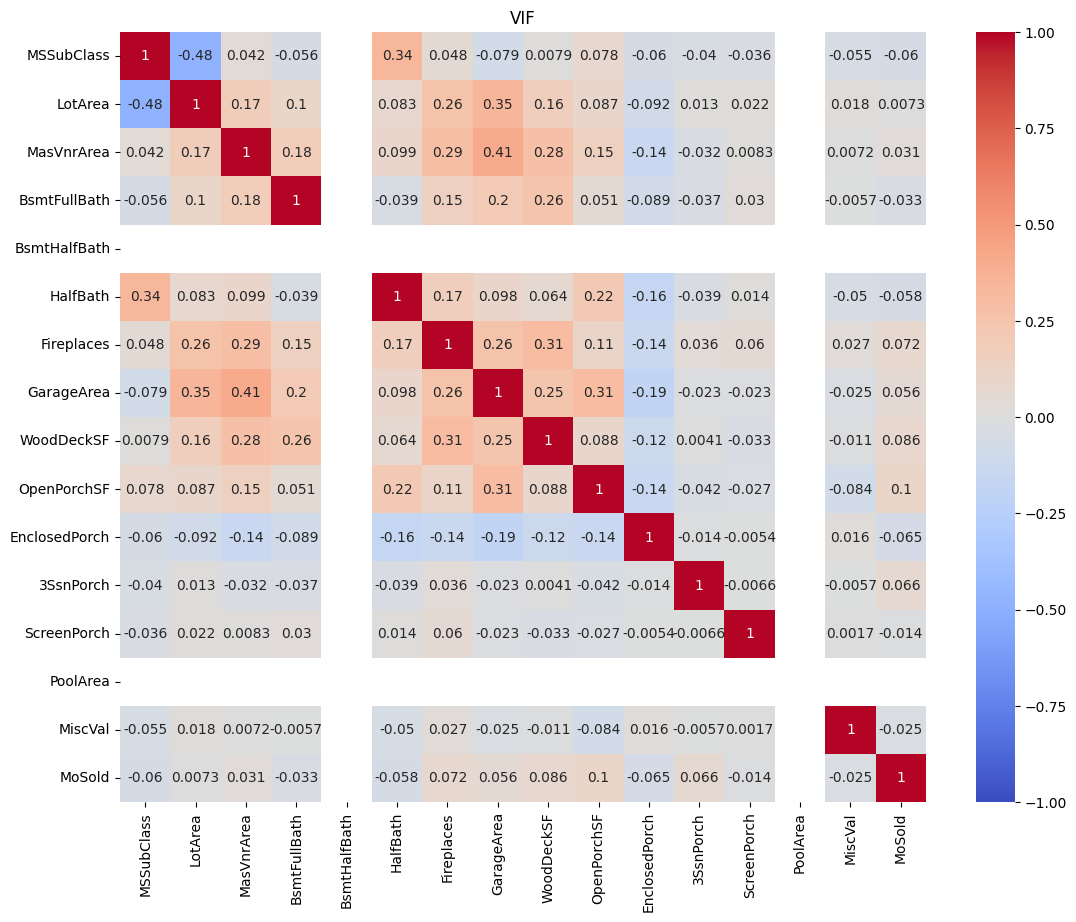


-----------------------------Found the correlations-----------------------------------------------


-----------------------------Encoded the data-----------------------------------------------

Algorithms: 

KNN
SVM
KMeans
Gradient Descent
Linear Regression
Logistic Regression
Lasso and Ridge Regression
Neural Networks



If you utilize any of these algorithms you can scale your data by giving 'Y' or else 'N' Y



Minmax scaled columns: 
 ['MSSubClass', 'LotArea', 'MasVnrArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageQual', 'GarageCond', 'SaleType', 'SaleCondition']

Standardized columns: 
 ['BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', '3SsnPorch', 'PoolArea', 'Street_Pave', 'LandSlope_Mod', 'LandSlope_Sev', 'Condition2_Norm', 'Condition2_RRNn', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'ExterCond_Gd', 'ExterCond_TA', 'BsmtCond_Gd', 'BsmtCond_TA', 'CentralAir_Y', 'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_P', 'PavedDrive_Y']

Scaled data

<class 'pandas.core.frame.DataFrame'>
Index: 8849 entries, 0 t

In [11]:
def intial_check(file_path, target_variable):
    if file_path.lower().endswith('.csv'):
        try:
            df = pd.read_csv(file_path)
        except pd.errors.ParserError:
            print("File cannot be parsed as a CSV.")
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        
        id_list = ['ID', 'Id', 'id', 'index', 'Index']
        id_drop = [col for col in df.columns if col in id_list]
        if id_drop:
            df = df.drop(columns=id_drop)
            print(f"Dropped columns: {', '.join(id_drop)}")
            
        drop_columns = []
        for col in df.columns:
            missing_count = df[col].isnull().sum()
            total_values = len(df[col])
            missing_percentage = (missing_count / total_values) * 100

            if missing_percentage > 40:
                drop_columns.append(col)
        print("Dropping columns with high missing data: ", list(drop_columns))
        df = df.drop(columns=drop_columns)
        
        df_columns = df.columns.tolist() 
        seen = {}
        duplicates = set()
        keep_indices = []

        for index, col in enumerate(df.columns):
            if col in seen:
                duplicates.add(col)
            else:
                seen[col] = index
                keep_indices.append(index)
    
        if duplicates:
            print("Duplicate columns:", list(duplicates))
        else:
            print("No duplicate columns found.")

        df = df.iloc[:, keep_indices]
        
        if target_variable in df_columns:
            print(f"The target variable '{target_variable}' is present in the DataFrame.")
        else:
            print(f"The target variable '{target_variable}' is missing in the DataFrame.")
            
        return df
    else:
        print("Oops :( The file is not a CSV file!")
        return None

def imputing(type_impute: int, df1: pd.DataFrame) -> pd.DataFrame:
    df = df1.copy()  # Create a copy to avoid modifying the original DataFrame
    
    print("Total Null value counts before imputation: \n",df.isnull().sum())
    
    if type_impute == 0:
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                df[column] = df[column].fillna(df[column].mean())
            else:
                df[column] = df[column].fillna(df[column].mode()[0])
    elif type_impute == 1:
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                df[column] = df[column].interpolate(method='linear')
            else:
                df[column] = df[column].fillna(df[column].mode()[0])
    else:
        raise ValueError("Invalid type. Expected 0, 1, or 2.")
        
    print("\nTotal Null value counts: \n",df.isnull().sum())
    return df


def handle_imbalanced_data(df,target,strategy='oversampling', k_neighbors=2):

    if strategy == 'oversampling':
        sampler = RandomOverSampler()
    elif strategy == 'undersampling':
        sampler = RandomUnderSampler()
    elif strategy == 'smote':
        sampler = SMOTE(k_neighbors=k_neighbors)
    else:
        raise ValueError("Invalid strategy. Choose from 'oversampling', 'undersampling', or 'smote'.")
        
    X_res, y_res=separate_target_column(df,target)
    X_res, y_res = sampler.fit_resample(X_res, y_res)
    df_balanced = pd.concat([X_res, y_res], axis=1)
    
    return df_balanced

def remove_outliers(raw_df):
    
    numerical_features = raw_df.select_dtypes(include=['float64', 'int64']).columns
    df = raw_df.copy()
    
    for col in numerical_features:
        z_scores = np.abs(stats.zscore(df[col]))
        threshold = 3
        outliers = z_scores > threshold
        df = df[~outliers]
        
    print(f"\nOriginal data count: {len(raw_df)}")
    print(f"After oultier removal data count: {len(df)}")
    
    return df



def separate_target_column(df, target_column):
    target = df[target_column]
    remaining_df = df.drop(columns=[target_column])
    return remaining_df, target



def plot_filtered_correlation_matrix(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64'])
    non_numerical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
    print("Before: ", numerical_columns.shape)
    
    numerical_columns = numerical_columns.fillna(numerical_columns.mean())
    
    vif = pd.DataFrame()
    vif['Feature'] = numerical_columns.columns
    vif["VIF"] = [variance_inflation_factor(numerical_columns.values, i) for i in range(numerical_columns.shape[1])]
    
    print("Initial VIF values: ")
    print(vif.sort_values(by="VIF", ascending=False))
    
    infinite_vif_features = vif[vif["VIF"] == np.inf]["Feature"].tolist()
    if infinite_vif_features:
        print(f"\nDropping columns with infinite VIF values: {infinite_vif_features}\n")
        numerical_columns = numerical_columns.drop(columns=infinite_vif_features)
        
    max_vif = 10
    remove_flag = True
    
    while remove_flag:
        vif = pd.DataFrame()
        vif['Feature'] = numerical_columns.columns
        vif["VIF"] = [variance_inflation_factor(numerical_columns.values, i) for i in range(numerical_columns.shape[1])]
        
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]
        
        if max_vif_feature['VIF'] > max_vif:
            numerical_columns = numerical_columns.drop(max_vif_feature['Feature'], axis=1)
            print(f"Removed variable with high VIF {max_vif_feature['Feature']} (VIF={max_vif_feature['VIF']})")
        else:
            remove_flag = False
            
    df_correlated = pd.concat([numerical_columns, df[non_numerical_columns]], axis=1)
    print("After: ", numerical_columns.shape)
    
    plt.figure(figsize=(13,10))
    plt.title("VIF")
    sns.heatmap(numerical_columns.corr(),annot=True,fmt='0.2g',cmap='coolwarm',vmin=-1,vmax=1)
    plt.show()
    
    return df_correlated

def encoding(features: pd.DataFrame) -> pd.DataFrame:
    for column in features.columns:
        if features[column].dtype == "object":
            if features[column].nunique() > 3:
                encoder = LabelEncoder()
                features[column] = encoder.fit_transform(features[column])
            else:
                encoder = OneHotEncoder(sparse_output=False, drop='first')
                encoded = encoder.fit_transform(features[[column]])
                encoded_features = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([column]), index=features.index)
                features.drop(columns=[column], inplace=True)
                features[encoded_features.columns] = encoded_features
    return features

def feature_scaling(df,target):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    non_numerical_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
    
    algorithms = ['KNN', 'SVM', 'KMeans', 'Gradient Descent', 'Linear Regression', 'Logistic Regression', 'Lasso and Ridge Regression', 'Neural Networks']
    
    print("Algorithms: \n")
    for algo in algorithms:
        print(algo)
        
    answer = input("\nIf you utilize any of these algorithms you can scale your data by giving 'Y' or else 'N'")
    
    if answer.upper() == 'Y':
        
        Minmaxscaler_algorithms = []
        Standardscaler_algorithms = []
        
        for col in numerical_columns:
            unique_count = df[col].nunique()
            
            if unique_count > 3:
                scaler = MinMaxScaler()
                Minmaxscaler_algorithms.append(col)
            else:
                scaler = StandardScaler()
                Standardscaler_algorithms.append(col)
            
            df[col] = scaler.fit_transform(df[[col]])
            
        print("\nMinmax scaled columns: \n", Minmaxscaler_algorithms)
        print("\nStandardized columns: \n", Standardscaler_algorithms)
        
        df_scaled = pd.concat([df[numerical_columns], df[non_numerical_columns]], axis=1)
        df_scaled[target.name] = target.values
        print("\nScaled data\n")
        
        return df_scaled
    else:
        df[target.name] = target.values
        return df
    


def preprocess_pipeline(file_path, target_column):
    df = intial_check(file_path,target_column)
    print("\n-----------------------------Initial check done-----------------------------------------------\n")
    df=imputing(1 ,df)
    print("\n-----------------------------Imputation Done-----------------------------------------------\n")
    df=handle_imbalanced_data(df,target_column)
    print("\n-----------------------------Balanced the data-----------------------------------------------\n")
    df = remove_outliers(df)
    print("\n-----------------------------Removed Outliers-----------------------------------------------\n")    
    remaining_df, target = separate_target_column(df, target_column)
    print("\n-----------------------------Seperated the input and output-----------------------------------------------\n")
    remaining_df = plot_filtered_correlation_matrix(remaining_df)
    print("\n-----------------------------Found the correlations-----------------------------------------------\n")
    remaining_df=encoding(remaining_df)
    print("\n-----------------------------Encoded the data-----------------------------------------------\n")
    preprocessed_df = feature_scaling(remaining_df,target)
    return preprocessed_df

file_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
target_column ='SalePrice'

processed_data = preprocess_pipeline(file_path, target_column)
processed_data.info()

In [12]:
processed_data.head()

,MSSubClass,LotArea,MasVnrArea,BsmtFullBath,BsmtHalfBath,HalfBath,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,...,ExterCond_Gd,ExterCond_TA,BsmtCond_Gd,BsmtCond_TA,CentralAir_Y,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SalePrice
0,0.285714,0.249485,0.295181,1.291423,0.0,1.220316,-0.980654,0.520418,0.000000,0.250000,...,-0.274011,0.302087,-0.219005,0.283662,0.242115,1.436314,-0.785960,-0.132202,0.264353,208500
2,0.285714,0.347186,0.243976,1.291423,0.0,1.220316,0.751443,0.577398,0.000000,0.172131,...,-0.274011,0.302087,-0.219005,0.283662,0.242115,1.436314,-0.785960,-0.132202,0.264353,223500
4,0.285714,0.452214,0.527108,1.291423,0.0,1.220316,0.751443,0.793922,0.428571,0.344262,...,-0.274011,0.302087,-0.219005,0.283662,0.242115,1.436314,-0.785960,-0.132202,0.264353,250000
6,0.000000,0.306501,0.280120,1.291423,0.0,-0.819460,0.751443,0.603989,0.569196,0.233607,...,-0.274011,0.302087,-0.219005,0.283662,0.242115,1.436314,-0.785960,-0.132202,0.264353,307000
10,0.000000,0.345441,0.000000,1.291423,0.0,-0.819460,-0.980654,0.364672,0.000000,0.000000,...,-0.274011,0.302087,-0.219005,0.283662,0.242115,-0.696227,1.272329,-0.132202,0.264353,129500
